# Understanding the `simulate` method in HARK
In this notebook we take a quick look at the simulate method in HARK. The purpose is to help you implement the required methods for your own class and to understand how `simulate` works. We use `IndShockConsumerType` to illustrate.

In [9]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
import HARK.ConsumptionSaving.ConsumerParameters as param 

When inheriting from `AgentType`, or classes that themselves
inherit from `AgentType`, you get the `simulate` method.

It will set the time to "Forward mode", determine the
number of periods to simulate, and simulate each period
using the `simOnePeriod` method. It will simulate `self.T_sim` times. It will then track all
variables in `self.track_vars`.

Let us look at the case of a standard life cycle model with parameters from `ConsumerParamters.init_lifecycle`. Note that we solve it. With no

In [10]:
pars = param.init_lifecycle
model = IndShockConsumerType(**pars)
model.solve()
model.T_sim = 8
model.track_vars

[]

Nothing there! What if we try to simulate?

In [11]:
model.initializeSim()
model.simulate()

We actually succesfully simulated all the agents, but if you look through the "contents" of `model`, no record was kept, because we hadn't asked it to.

We now also specify that we want to track the normalized resources and agent age. Note, as agents die off, new agents take their place as newborns.

In [13]:
model.track_vars = ['mNrmNow', 't_age']
model.initializeSim()
model.simulate()

In [14]:
model.mNrmNow_hist

array([[1.47254653, 1.75334988, 2.29001854, ..., 2.43984884, 1.46813265,
        1.1738894 ],
       [1.67750658, 1.86982108, 2.16086098, ..., 2.14471441, 1.67460177,
        1.02799918],
       [1.2716236 , 2.24339761, 1.82568699, ..., 1.84334403, 1.860793  ,
        1.66701884],
       ...,
       [1.34687863, 1.02467664, 1.22392536, ..., 2.10987414, 0.95409672,
        1.27820716],
       [1.27766786, 0.99441941, 1.195255  , ..., 1.86190268, 1.25429289,
        0.52310628],
       [1.30322026, 2.71866829, 0.99642317, ..., 0.82258437, 1.51719858,
        1.01652988]])

In [15]:
model.t_age_hist

array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 1.],
       ...,
       [1., 6., 3., ..., 2., 6., 4.],
       [2., 7., 4., ..., 3., 1., 5.],
       [3., 1., 5., ..., 4., 2., 6.]])

We can then plot a relationship between the normalized resources and age.

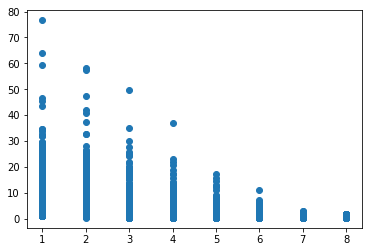

In [16]:
import matplotlib.pyplot as plt
plt.scatter(model.t_age_hist, model.mNrmNow_hist)

## How is it implemented

We stated earlier that to simulate a data set,  `AgentType` uses the `simOnePeriod`. So to understand `simulate`, we basically need to understand what
`simOnePeriod` does. `simOnePeriod` calls

- getMortility()
- getShocks() - or if self.read_shocks is true: readShocks()
- getStates()
- getControls()
- getPostStates()

then it increments people's ages and shifts their cycle (resetting
if the cycle length is reached). The number of agents is determined by the
integer stored in self.AgentCount.

`getMortality()` figures out who dies (through `simDeath()`), and
gives birth to people using `simBirth()` in order to repopulate the
dataset.

`getShocks()` generates shocks for individuals. Alternatively, readShocks()
can be used (if self.read_shocks==True) to read the shock from the current simulation
time `self.t_sim` from a pre-specified shock history in `self.name_hist` for all "name"
in `self.shock_vars`.

`getStates()` calculates the current states using last period's post-decision states
and current period shocks (or whatever is implemented by the class in question).

`getControls()` calculates controls given shocks and states. 

`getPostStates()` calculates post-decision states given shocks, states and controls.

Now, there are some interesting things we can look at. First, let's look at the atttribute `shock_vars`.

In [17]:
model.shock_vars

['PermShkNow', 'TranShkNow']

Here we see, that `model.shock_vars` contains the `PermShkNow` and `TranShkNow` shock names. This tells us that `getShocks` will generate (or "get") these shocks for all agents given the specified distribution.